In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FuncFormatter

sns.set()
sns.set_style("whitegrid")

out_file_path = "../../img/"


In [4]:
cu_data = pd.read_csv("../data/spsv-cusparse12-4090.csv",
                      header=None,
                      names=[
                          "cu_pro", "mat", "x", "y", "compute", "m", "n", "nnz",
                          "cu_time", "cu_gflops"
                      ])
work_est = pd.read_csv("../data/level-info.csv",
                      header=None,
                      names=[
                          "mat", "nlevel", "parallelism_min", "parallelism_avg", "parallelism_max"
                      ])
cu_data=cu_data.loc[:,["cu_pro", "mat", "nnz", "cu_time", "cu_gflops"]]

cu_data = pd.merge(cu_data, work_est, how='inner', on='mat')
# print(cu_data)

cu_info = cu_data["cu_pro"].unique()

for diff_pro in cu_info:
    temp_data = cu_data[cu_data["cu_pro"].isin([diff_pro])]
    exec("%s=temp_data.copy()" % diff_pro)
print(cu_info)

['exe_sptrsv_csr_32' 'exe_sptrsv_csr_64']


In [5]:
sync_data = pd.read_csv("../data/sptrsv-sync-free-4090.csv",
                      header=None,
                      names=[
                          "sync_pro", "mat", "x", "y", "compute", "m", "n", "nnz",
                          "sync_time", "sync_gflops"
                      ])
sync_data=sync_data.loc[:,["sync_pro", "mat", "nnz", "sync_time", "sync_gflops"]]

sync_data = pd.merge(sync_data, work_est, how='inner', on='mat')
# print(sync_data)

sync_info = sync_data["sync_pro"].unique()

for diff_pro in sync_info:
    temp_data = sync_data[sync_data["sync_pro"].isin([diff_pro])]
    exec("%s=temp_data.copy()" % diff_pro)
print(sync_info)

['sptrsv_sync_free_64' 'sptrsv_sync_free_32' 'sptrsv_sync_free_16']


In [6]:
rec_data = pd.read_csv("../data/sptrsv-rec-4090.csv",
                      header=None,
                      names=[
                          "rec_pro", "mat", "x", "y", "compute", "m", "n", "nnz",
                          "rec_time", "rec_gflops"
                      ])
rec_data=rec_data.loc[:,["rec_pro", "mat", "nnz", "rec_time", "rec_gflops"]]

rec_data = pd.merge(rec_data, work_est, how='inner', on='mat')
# print(rec_data)

rec_info = rec_data["rec_pro"].unique()

for diff_pro in rec_info:
    temp_data = rec_data[rec_data["rec_pro"].isin([diff_pro])]
    exec("%s=temp_data.copy()" % diff_pro)
print(rec_info)

['sptrsv_rec_32' 'sptrsv_rec_64' 'sptrsv_rec_16']


In [7]:
cu_data_64 = exe_sptrsv_csr_64[["mat", "cu_gflops", "parallelism_avg"]]
cu_data_32 = exe_sptrsv_csr_32[["mat", "cu_gflops"]]

cu_data_comp = pd.merge(cu_data_64, cu_data_32, how='inner', on='mat', suffixes=("_64","_32"))

cu_data_comp["speedup_32"] = cu_data_comp["cu_gflops_32"] / cu_data_comp["cu_gflops_64"]

# print(cu_data_comp)

In [8]:
sync_data_64 = sptrsv_sync_free_64[["mat", "sync_gflops", "parallelism_avg"]]
sync_data_32 = sptrsv_sync_free_32[["mat", "sync_gflops"]]
sync_data_16 = sptrsv_sync_free_16[["mat", "sync_gflops"]]

sync_data_comp = pd.merge(sync_data_64, sync_data_32, how='inner', on='mat', suffixes=("_64",""))
sync_data_comp = pd.merge(sync_data_comp, sync_data_16, how='inner', on='mat', suffixes=("_32","_16"))

sync_data_comp["speedup_32"] = sync_data_comp["sync_gflops_32"] / sync_data_comp["sync_gflops_64"]
sync_data_comp["speedup_16"] = sync_data_comp["sync_gflops_16"] / sync_data_comp["sync_gflops_64"]

# print(sync_data_comp)

In [9]:
rec_data_64 = sptrsv_rec_64[["mat", "rec_gflops", "parallelism_avg"]]
rec_data_32 = sptrsv_rec_32[["mat", "rec_gflops"]]
rec_data_16 = sptrsv_rec_16[["mat", "rec_gflops"]]

rec_data_comp = pd.merge(rec_data_64, rec_data_32, how='inner', on='mat', suffixes=("_64",""))
rec_data_comp = pd.merge(rec_data_comp, rec_data_16, how='inner', on='mat', suffixes=("_32","_16"))

rec_data_comp["speedup_32"] = rec_data_comp["rec_gflops_32"] / rec_data_comp["rec_gflops_64"]
rec_data_comp["speedup_16"] = rec_data_comp["rec_gflops_16"] / rec_data_comp["rec_gflops_64"]

# print(rec_data_comp)

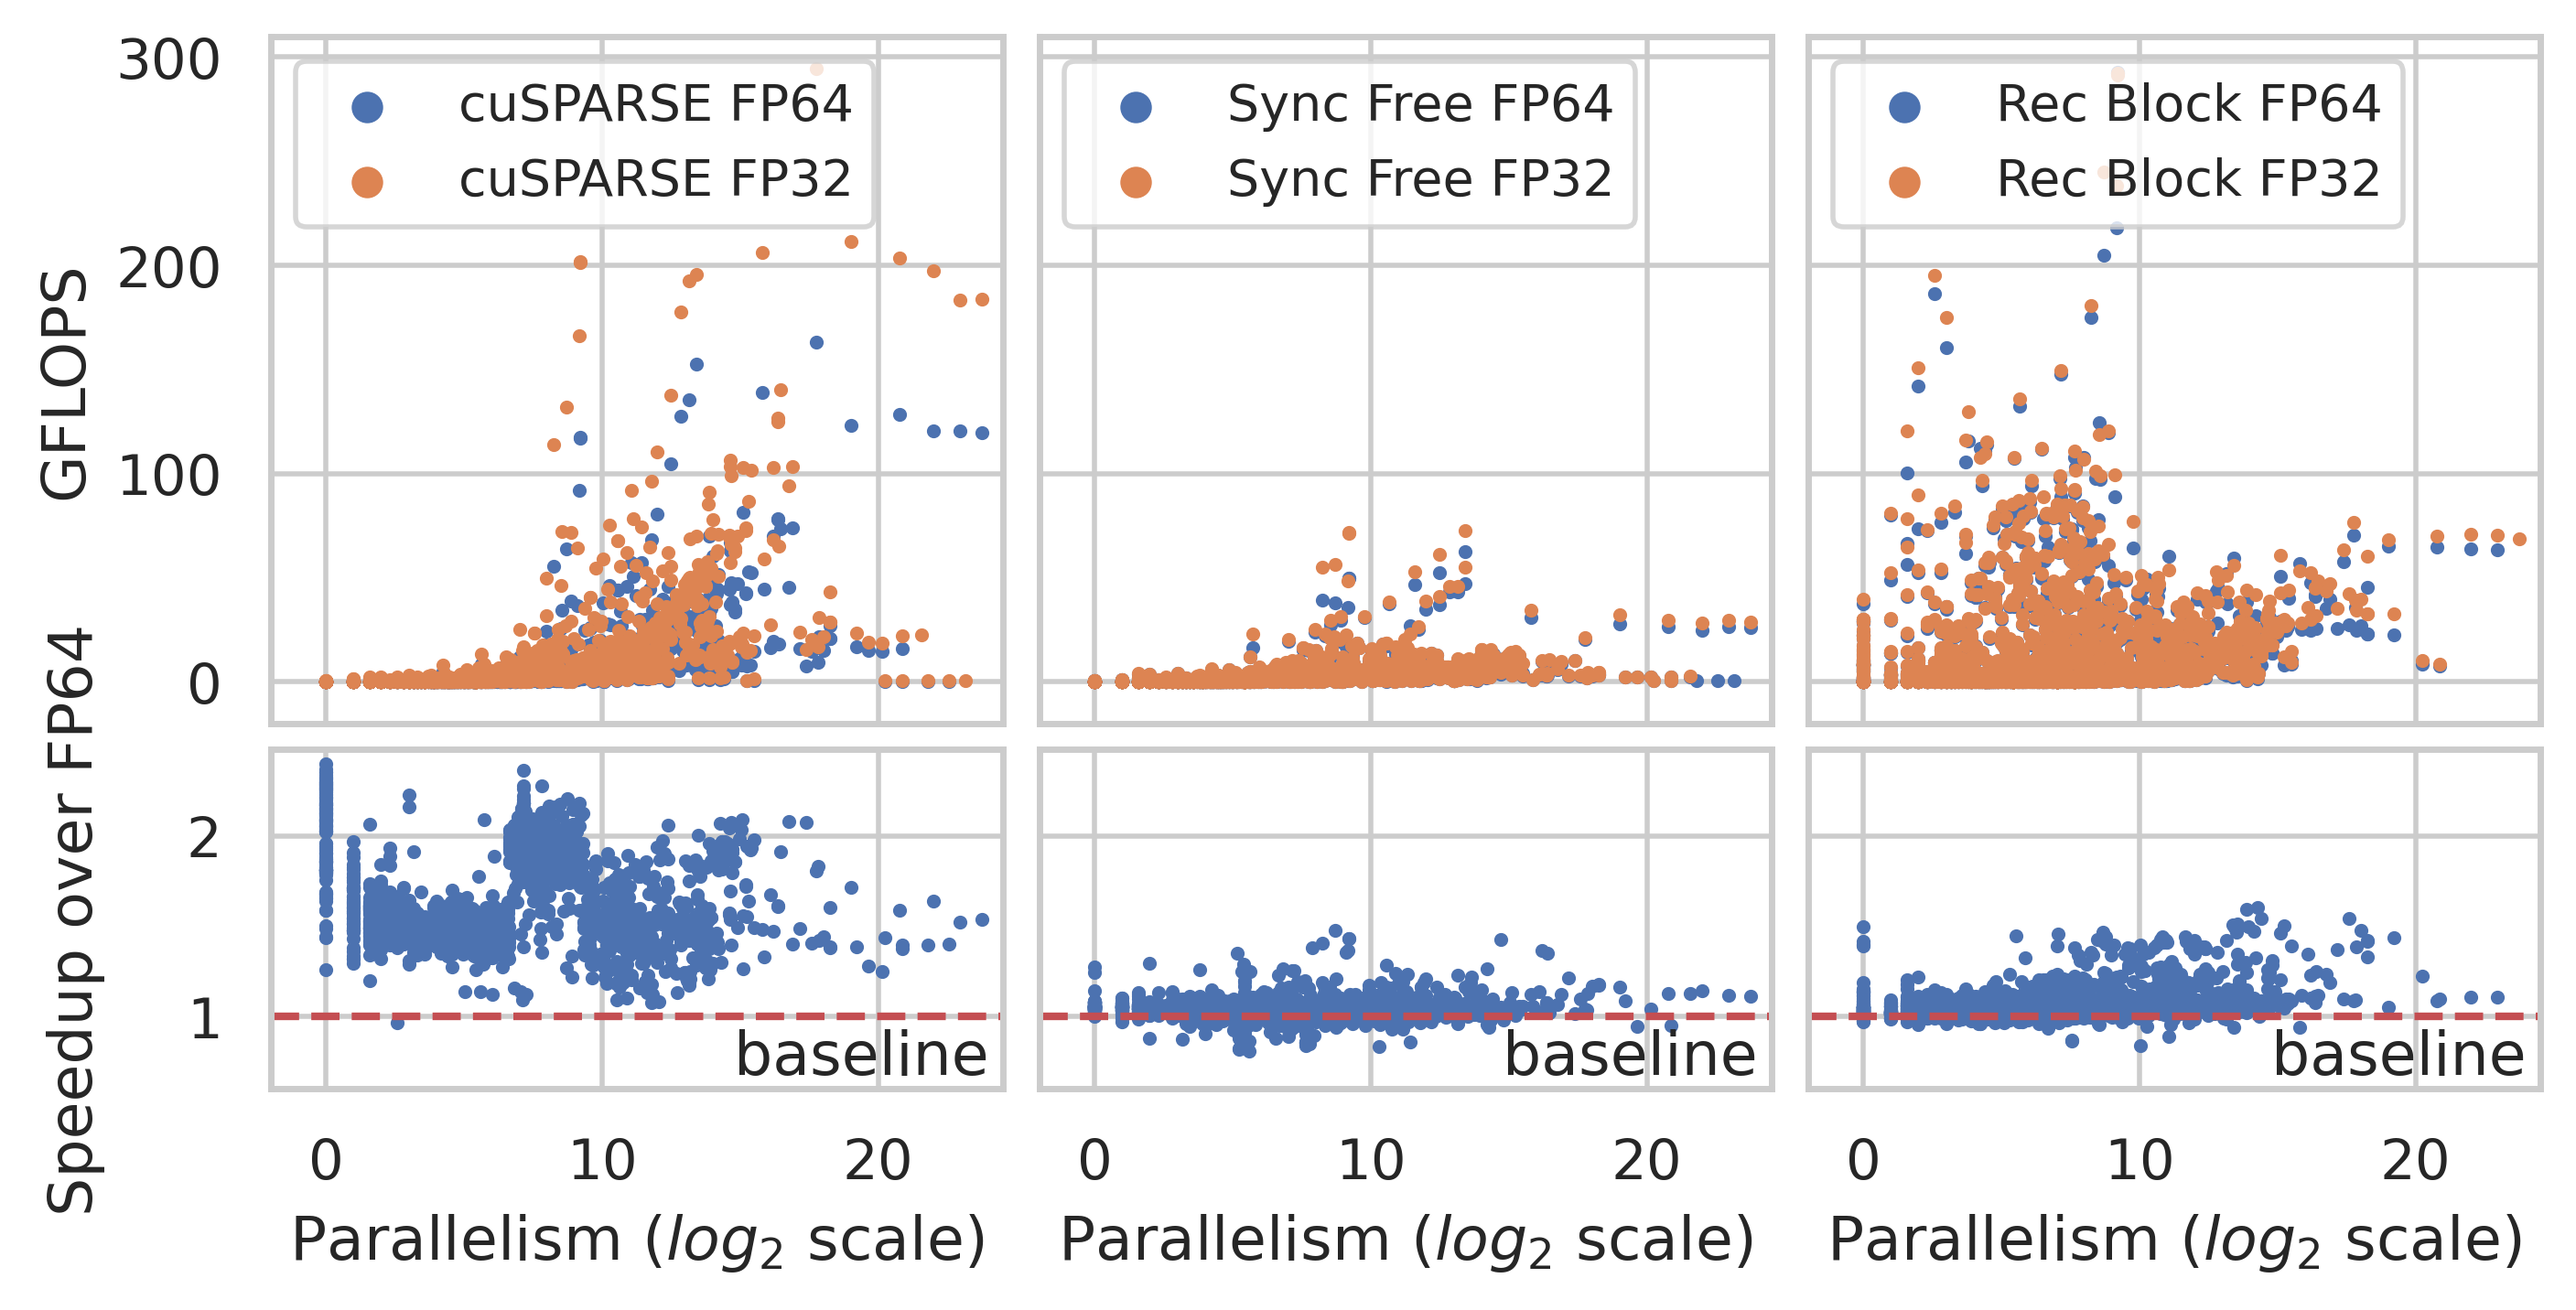

In [10]:
# plt.figure(figsize=(15, 10), dpi=400)
# plt.figure(figsize=(10, 6), dpi=400)
plt.figure(figsize=(8, 5), dpi=400)

plt.subplots_adjust(wspace=0.05, hspace=0.05)

dot_size = 3
legend_font_size = 10

plt.subplot(231)

plt.scatter(np.log2(exe_sptrsv_csr_64["parallelism_avg"]),
            (exe_sptrsv_csr_64["cu_gflops"]),
            label="cuSPARSE FP64",
            s=dot_size)
plt.scatter(np.log2(exe_sptrsv_csr_32["parallelism_avg"]),
            (exe_sptrsv_csr_32["cu_gflops"]),
            label="cuSPARSE FP32",
            s=dot_size)

plt.legend(loc=2, fontsize=legend_font_size, markerscale=3)
plt.xlim(-2, 24.5)
plt.ylim(-20, 310)
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
# plt.xlabel("Parallelism (log scale)")

plt.ylabel("GFLOPS")

# --------------------------------------------------------------------------------------------

plt.subplot(232)

plt.scatter(
            np.log2(sptrsv_sync_free_64["parallelism_avg"]),
            (sptrsv_sync_free_64["sync_gflops"]),
            label="Sync Free FP64",
            s=dot_size)
plt.scatter(
            np.log2(sptrsv_sync_free_32["parallelism_avg"]),
            (sptrsv_sync_free_32["sync_gflops"]),
            label="Sync Free FP32",
            s=dot_size)

plt.legend(loc=2, fontsize=legend_font_size, markerscale=3)
plt.xlim(-2, 24.5)
plt.ylim(-20, 310)

ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

# --------------------------------------------------------------------------------------------

plt.subplot(233)

plt.scatter(
            np.log2(sptrsv_rec_64["parallelism_avg"]),
            (sptrsv_rec_64["rec_gflops"]),
            label="Rec Block FP64",
            s=dot_size)
plt.scatter(
            np.log2(sptrsv_rec_32["parallelism_avg"]),
            (sptrsv_rec_32["rec_gflops"]),
            label="Rec Block FP32",
            s=dot_size)

plt.legend(loc=2, fontsize=legend_font_size, markerscale=3)
plt.xlim(-2, 24.5)
plt.ylim(-20, 310)

ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

# --------------------------------------------------------------------------------------------

plt.subplot(437)

plt.scatter(np.log2(cu_data_comp["parallelism_avg"]),
            (cu_data_comp["speedup_32"]),
            label="cuSPARSE\nFP32 speedup over FP64",
            s=dot_size)


text_her_loc = 24
text_ver_loc = -0.32
plt.axhline(1, color="r", linestyle="--")
plt.text(text_her_loc, 1 + text_ver_loc, 'baseline', horizontalalignment="right")
plt.xlim(-2, 24.5)
plt.ylim(0.6, 2.48)

# plt.legend(loc=2, fontsize=legend_font_size)

plt.xlabel("Parallelism ($log_2$ scale)")
plt.ylabel("Speedup over FP64",labelpad=16)

# --------------------------------------------------------------------------------------------

plt.subplot(438)

plt.scatter(np.log2(sync_data_comp["parallelism_avg"]),
            (sync_data_comp["speedup_32"]),
            label="Sync Free\nFP32 speedup over FP64",
            s=dot_size)

plt.axhline(1, color="r", linestyle="--")
plt.text(text_her_loc, 1 + text_ver_loc, 'baseline', horizontalalignment="right")
plt.xlim(-2, 24.5)
plt.ylim(0.6, 2.48)

# plt.legend(loc=2, fontsize=legend_font_size)

plt.xlabel("Parallelism ($log_2$ scale)")
ax = plt.gca()
ax.axes.yaxis.set_ticklabels([])

# --------------------------------------------------------------------------------------------

plt.subplot(439)

plt.scatter(np.log2(rec_data_comp["parallelism_avg"]),
            (rec_data_comp["speedup_32"]),
            label="Rec Block\nFP32 speedup over FP64",
            s=dot_size)

plt.axhline(1, color="r", linestyle="--")
plt.text(text_her_loc, 1 + text_ver_loc, 'baseline', horizontalalignment="right")
plt.xlim(-2, 24.5)
plt.ylim(0.6, 2.48)

# plt.legend(loc=2, fontsize=legend_font_size)

plt.xlabel("Parallelism ($log_2$ scale)")
ax = plt.gca()
ax.axes.yaxis.set_ticklabels([])

# --------------------------------------------------------------------------------------------

# plt.show()
plt.savefig ("sptrsv_4090.pdf", dpi= 400, format = "pdf", bbox_inches='tight', pad_inches=0.0) 


In [11]:
print(cu_data_comp["speedup_32"].mean())
print(cu_data_comp.loc[cu_data_comp["speedup_32"].idxmax()]["speedup_32"])

print("rec:")
print(rec_data_comp["speedup_32"].mean())
print(rec_data_comp.loc[rec_data_comp["speedup_32"].idxmax()]["speedup_32"])


1.6325908282006933
3.560782076095962
rec:
1.071790679626141
1.6052460912963098


In [12]:
# print(cu_data_comp)
# print(rec_data_comp)
all_data_comp = pd.merge(cu_data_comp, rec_data_comp, how='inner', on='mat')
# print(all_data_comp)
all_data_comp["rec_speedup_64"] = all_data_comp["cu_gflops_64"] / all_data_comp["rec_gflops_64"]
all_data_comp["rec_speedup_32"] = all_data_comp["cu_gflops_32"] / all_data_comp["rec_gflops_32"]

print(all_data_comp["rec_speedup_64"].mean())
print(all_data_comp.loc[all_data_comp["rec_speedup_64"].idxmax()]["rec_speedup_64"])

print(all_data_comp["rec_speedup_32"].mean())
print(all_data_comp.loc[all_data_comp["rec_speedup_32"].idxmax()]["rec_speedup_32"])

1.076729497320999
4.697789411673761
1.4995576217404358
5.692804050534962


In [13]:
print("cu sptrsv speedup fp32", cu_data_comp["speedup_32"].max())

print("sync sptrsv speedup fp32", sync_data_comp["speedup_32"].max())

print("rec sptrsv speedup fp32", rec_data_comp["speedup_32"].max())

print("cu sptrsv fp64 max", all_data_comp["cu_gflops_64"].max())
print("cu sptrsv fp32 max", all_data_comp["cu_gflops_32"].max())

print("sync sptrsv fp64 max", sync_data_comp["sync_gflops_64"].max())
print("sync sptrsv fp32 max", sync_data_comp["sync_gflops_32"].max())

print("rec sptrsv fp64 max", all_data_comp["rec_gflops_64"].max())
print("rec sptrsv fp32 max", all_data_comp["rec_gflops_32"].max())

cu sptrsv speedup fp32 3.560782076095962
sync sptrsv speedup fp32 1.4784679055834304
rec sptrsv speedup fp32 1.6052460912963098
cu sptrsv fp64 max 162.958175
cu sptrsv fp32 max 294.412169
sync sptrsv fp64 max 49.965664
sync sptrsv fp32 max 71.553411
rec sptrsv fp64 max 292.860861
rec sptrsv fp32 max 292.276944
